In [292]:
#  !pip install sidetable
#  !pip install tabulate

In [293]:
import pandas as pd;import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sidetable as stb

from IPython.display import HTML, display
import tabulate
%matplotlib inline

## Read the data to Pandas Data Frame

In [294]:
df = pd.read_csv("https://raw.githubusercontent.com/psiva2019/CustmerChurn/master/CustumerChurnData.csv",error_bad_lines=False)
df.head()

,AccountID,Churn,Tenure,City_Tier,CC_Contacted_LY,Payment,Gender,Service_Score,Account_user_count,account_segment,CC_Agent_Score,Marital_Status,rev_per_month,Complain_ly,rev_growth_yoy,coupon_used_for_payment,Day_Since_CC_connect,cashback,Login_device
0,20000,1,4,3.0,6.0,Debit Card,Female,3.0,3,Super,2.0,Single,9,1.0,11,1,5,160,Mobile
1,20001,1,0,1.0,8.0,UPI,Male,3.0,4,Regular Plus,3.0,Single,7,1.0,15,0,0,121,Mobile
2,20002,1,0,1.0,30.0,Debit Card,Male,2.0,4,Regular Plus,3.0,Single,6,1.0,14,0,3,NaN,Mobile
3,20003,1,0,3.0,15.0,Debit Card,Male,2.0,4,Super,5.0,Single,8,0.0,23,0,3,134,Mobile
4,20004,1,0,1.0,12.0,Credit Card,Male,2.0,3,Regular Plus,5.0,Single,3,0.0,11,1,3,130,Mobile


## Data Report

In [295]:
#Shape of the Data
print('****Shape of the hotel data****')
print('********************************')
print('No of rows\t:\t{}\nNo of columns\t:\t{}'.format(df.shape[0],df.shape[1]))

****Shape of the hotel data****
********************************
No of rows	:	11260
No of columns	:	19


In [296]:
print('****Show infomation of the train data****')
print('***********************************')
df.info()

****Show infomation of the train data****
***********************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11260 entries, 0 to 11259
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AccountID                11260 non-null  int64  
 1   Churn                    11260 non-null  int64  
 2   Tenure                   11158 non-null  object 
 3   City_Tier                11148 non-null  float64
 4   CC_Contacted_LY          11158 non-null  float64
 5   Payment                  11151 non-null  object 
 6   Gender                   11152 non-null  object 
 7   Service_Score            11162 non-null  float64
 8   Account_user_count       11148 non-null  object 
 9   account_segment          11163 non-null  object 
 10  CC_Agent_Score           11144 non-null  float64
 11  Marital_Status           11048 non-null  object 
 12  rev_per_month            11158 non-null  object 
 13

In [297]:
#Check for duplicate values
print('****Duplicates data in the train dataset without EmployeeID Column****')
print('**********************************************************************')

dups = df.loc[:, ~df.columns. isin(['EmployeeID'])].duplicated().sum()
if dups ==0:
    print('There is no duplicate values in the data.') 
else:
    print('There are {} duplicates in the data which is {}% of total data'.format(dups,round((dups/df.shape[0])*100,2)))

****Duplicates data in the train dataset without EmployeeID Column****
**********************************************************************
There is no duplicate values in the data.


In [298]:
#Check for missing value
print('****Missing Values in the Dataset****')
print('*************************************')
msv = df.isnull().sum()[df.isnull().sum()>0]
if msv.empty:
    print('There is no missing values in the data.') 
else:
    for i in range(msv.count()):
        print('{} Missing values in {} which is {}% of total data ({})'.format(msv[i],msv.index[i],round(((msv[i]/df.shape[0])*100),2),df[msv.index[i]].dtype))

****Missing Values in the Dataset****
*************************************
102 Missing values in Tenure which is 0.91% of total data (object)
112 Missing values in City_Tier which is 0.99% of total data (float64)
102 Missing values in CC_Contacted_LY which is 0.91% of total data (float64)
109 Missing values in Payment which is 0.97% of total data (object)
108 Missing values in Gender which is 0.96% of total data (object)
98 Missing values in Service_Score which is 0.87% of total data (float64)
112 Missing values in Account_user_count which is 0.99% of total data (object)
97 Missing values in account_segment which is 0.86% of total data (object)
116 Missing values in CC_Agent_Score which is 1.03% of total data (float64)
212 Missing values in Marital_Status which is 1.88% of total data (object)
102 Missing values in rev_per_month which is 0.91% of total data (object)
357 Missing values in Complain_ly which is 3.17% of total data (float64)
357 Missing values in Day_Since_CC_connect which

In [299]:
def display_dataframe(df):
    numeric_col_mask = df.dtypes.apply(lambda d: issubclass(np.dtype(d).type, str))

    # Dict used to center the table headers
    d = dict(selector="th",
        props=[('text-align', 'left')])

    # Style
    display(df.style.set_properties(subset=df.columns[numeric_col_mask], 
                            **{'width':'15em', 'height':'3em','text-align':'left','border-color': 'white','border-style' :'solid'})\
            .set_properties(subset=df.columns[~numeric_col_mask], 
                            **{'width':'15em', 'text-align':'left','border-color':'Black','border-width':'thin'})\
            .format(lambda x: '{:,.0f}'.format(x) if x > 1e3 else '{:,.2f}'.format(x), # format the numeric values
                    subset=pd.IndexSlice[:,df.columns[numeric_col_mask]])\
            .hide_index()\

#            .highlight_max('color: green')\
            .set_table_styles([d])) # center the header

In [300]:
def check_sp(Vars,fixit,data_df):
  tot = len(Vars['num'])+len(Vars['chars'])

  s = [[None for j in range(3)] for i in range(tot)]
  i=0
  for type_var in Vars:
    for var in Vars[type_var]:
      livars=[]
      li=data_df[var].unique()
      if(type_var=='num'):
        livars = list(filter(lambda x: (str(x).replace('.','').isdigit()!=True and str(x)!='nan'),li))
        if(fixit==True):
          for k in livars:
            data_df[var].replace(k,np.nan,inplace=True)
      else:
        li1 = list(filter(lambda x: (str(x).replace(' ','').isalpha()!=True and str(x)!='nan'),li))
        pattern = r'\W'
        
        li2 = []
        for j in li1:
          find = re.compile(pattern)
          ff = find.findall(j.replace(' ',''))[0]
          li2.append(ff)
        livars = list(set(li2))
      s[i][0] = var
      s[i][1] = livars if(livars!=[]) else 'No Special Chars'
      s[i][2] = 'Numeric' if(type_var=='num') else 'Charecter'
      i=i+1
  rdf = pd.DataFrame(data=s,columns=['Column','SpecialChars','DataType'])
  return(rdf)

In [301]:
Vars = {'num': ['Tenure','Account_user_count','rev_per_month','coupon_used_for_payment','Day_Since_CC_connect','cashback'],'chars':['account_segment','Payment','Gender','Marital_Status','Login_device'] }

spdf = check_sp(Vars,True,df)
display_dataframe(spdf)

Column,SpecialChars,DataType
Tenure,['#'],Numeric
Account_user_count,['@'],Numeric
rev_per_month,['+'],Numeric
coupon_used_for_payment,"['#', '$', '*']",Numeric
Day_Since_CC_connect,['$'],Numeric
cashback,['$'],Numeric
account_segment,['+'],Charecter
Payment,No Special Chars,Charecter
Gender,No Special Chars,Charecter
Marital_Status,No Special Chars,Charecter


In [302]:
df['account_segment'].value_counts()

Super           4062
Regular Plus    3862
HNI             1639
Super Plus       771
Regular          520
Regular +        262
Super +           47
Name: account_segment, dtype: int64

In [303]:
df['Login_device'].value_counts()

Mobile      7482
Computer    3018
&&&&         539
Name: Login_device, dtype: int64

In [304]:
df['account_segment'].replace('Super +','Super Plus',inplace=True)
df['account_segment'].replace('Regular +','Regular Plus',inplace=True)
df['Login_device'].replace('&&&&','Mobile',inplace=True)

df['Gender'].replace('Male','M',inplace=True)
df['Gender'].replace('Female','F',inplace=True)

In [305]:
spdf = check_sp(Vars,False,df)
display_dataframe(spdf)

Column,SpecialChars,DataType
Tenure,No Special Chars,Numeric
Account_user_count,No Special Chars,Numeric
rev_per_month,No Special Chars,Numeric
coupon_used_for_payment,No Special Chars,Numeric
Day_Since_CC_connect,No Special Chars,Numeric
cashback,No Special Chars,Numeric
account_segment,No Special Chars,Charecter
Payment,No Special Chars,Charecter
Gender,No Special Chars,Charecter
Marital_Status,No Special Chars,Charecter


In [306]:
Vars = {'num': ['Tenure','rev_per_month','cashback','CC_Contacted_LY'],'chars':['Complain_ly','CC_Agent_Score','Service_Score','City_Tier','Account_user_count','coupon_used_for_payment','Day_Since_CC_connect','account_segment','Payment','Gender','Marital_Status','Login_device'] }

for vars in Vars['chars']:
  df[vars].fillna(df[vars].mode()[0],inplace=True)

for vars in Vars['num']:
  df[vars].fillna(df[vars].median(),inplace=True)
  if(df[vars].dtype=='object'):
    df[vars] = df[vars].astype('int64')

In [307]:
#Check for missing value
print('****Missing Values in the Dataset****')
print('*************************************')
msv = df.isnull().sum()[df.isnull().sum()>0]
if msv.empty:
    print('There is no missing values in the data.') 
else:
    for i in range(msv.count()):
        print('{} Missing values in {} which is {}% of total data ({})'.format(msv[i],msv.index[i],round(((msv[i]/df.shape[0])*100),2),df[msv.index[i]].dtype))

****Missing Values in the Dataset****
*************************************
There is no missing values in the data.


### Univarient Analsyis

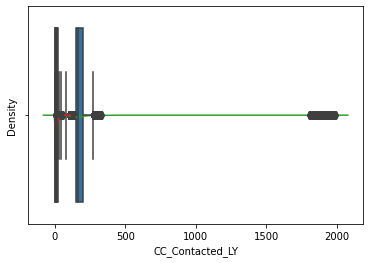

In [311]:

for var in Vars['num']:
  sns.distplot(df[var])
  sns.boxplot(df[var])